In [6]:
!sudo apt-get --reinstall install ttf-mscorefonts-installer

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 1 reinstalled, 0 to remove and 42 not upgraded.
Need to get 27.6 kB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/multiverse amd64 ttf-mscorefonts-installer all 3.6ubuntu2 [27.6 kB]
Fetched 27.6 kB in 0s (104 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open

In [1]:
import matplotlib.pyplot as plt

In [4]:
plt.rcParams["font.family"] = "Times"

Text(0.5, 1.0, 'lfd')

findfont: Font family ['Times'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times'] not found. Falling back to DejaVu Sans.


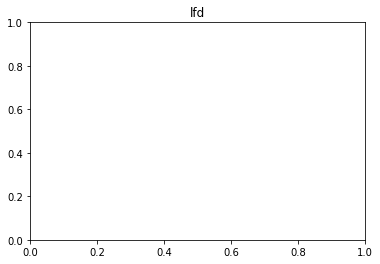

In [5]:
plt.title("lfd")

In [6]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-29adc1d4-a2de-e4d8-5154-85a893af899d)


In [7]:
! git clone https://github.com/google-research/google-research.git
! pip install git+https://github.com/deepmind/dm-haiku
! pip install scipy==1.7.3
! pip install numpyro

import sys
import jax
import matplotlib
import seaborn as sns
from matplotlib import pyplot as plt

sys.path.append("google-research/")
from bnn_hmc.utils import checkpoint_utils

%matplotlib inline

Cloning into 'google-research'...
remote: Enumerating objects: 52131, done.
remote: Counting objects: 100% (245/245), done.
remote: Compressing objects: 100% (168/168), done.
remote: Total 52131 (delta 89), reused 211 (delta 68), pack-reused 51886
Receiving objects: 100% (52131/52131), 335.97 MiB | 21.36 MiB/s, done.
Resolving deltas: 100% (30862/30862), done.
Checking out files: 100% (14292/14292), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/deepmind/dm-haiku to /tmp/pip-req-build-4givl0jy
  Running command git clone -q https://github.com/deepmind/dm-haiku /tmp/pip-req-build-4givl0jy
  Created wheel for dm-haiku: filename=dm_haiku-0.0.7.dev0-py3-none-any.whl size=599519 sha256=ef783d749473f29374271402ab030b47f29e7301d35cb9986e1aa38c6a925453
  Stored in directory: /tmp/pip-ephem-wheel-cache-nwi3toi3/wheels/06/28/69/ebaac5b2435641427299f29d88d005fb4e2627f4a108f0bdbc
Successfully built dm-haiku
Look

In [8]:
!gsutil -m cp -r gs://gresearch/bnn-posteriors/v1/hmc/cifar10/ .

Copying gs://gresearch/bnn-posteriors/v1/hmc/cifar10/state-0.pkl...
Copying gs://gresearch/bnn-posteriors/v1/hmc/cifar10/state-1.pkl...
Copying gs://gresearch/bnn-posteriors/v1/hmc/cifar10/state-10.pkl...
Copying gs://gresearch/bnn-posteriors/v1/hmc/cifar10/state-100.pkl...
Copying gs://gresearch/bnn-posteriors/v1/hmc/cifar10/state-101.pkl...
Copying gs://gresearch/bnn-posteriors/v1/hmc/cifar10/state-102.pkl...
Copying gs://gresearch/bnn-posteriors/v1/hmc/cifar10/state-103.pkl...
Copying gs://gresearch/bnn-posteriors/v1/hmc/cifar10/state-104.pkl...
Copying gs://gresearch/bnn-posteriors/v1/hmc/cifar10/state-105.pkl...
Copying gs://gresearch/bnn-posteriors/v1/hmc/cifar10/state-106.pkl...
Copying gs://gresearch/bnn-posteriors/v1/hmc/cifar10/state-107.pkl...
Copying gs://gresearch/bnn-posteriors/v1/hmc/cifar10/state-108.pkl...
Copying gs://gresearch/bnn-posteriors/v1/hmc/cifar10/state-109.pkl...
Copying gs://gresearch/bnn-posteriors/v1/hmc/cifar10/state-11.pkl...
Copying gs://gresearch/bnn

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
import tensorflow_datasets as tfds
import tensorflow as tf

import os

In [11]:
def get_params_and_state(chain_id, sample_id):
  ckpt_dict = checkpoint_utils.load_checkpoint(
      "cifar10/state-{}.pkl".format(sample_id))
  params = ckpt_dict["params"]
  net_state = ckpt_dict["net_state"]

  params = jax.tree_map(lambda p: p[chain_id], params)
  net_state = jax.tree_map(lambda p: p[chain_id], net_state)
  return params, net_state

In [12]:
from jax import numpy as jnp
import numpy as onp

from bnn_hmc.utils import models
from bnn_hmc.utils import metrics
from bnn_hmc.utils import precision_utils
from bnn_hmc.utils import data_utils


net_apply, net_init = models.get_model("resnet20_frn_swish", {"num_classes": 10})
net_apply = precision_utils.rewrite_high_precision(net_apply)

In [13]:
from tqdm import tqdm

def compute_logits(batch, num_samples=240):
    n_batch = test_batch.shape[0]
    num_chains = 3
    logits = onp.zeros((n_batch, num_chains, num_samples, num_classes))
    for chain_i in range(3):
        for s_i, sample_index in tqdm(enumerate(range(50, 50+num_samples))):
            params, net_state = get_params_and_state(chain_i, sample_index)
            preds, _ = net_apply(params, net_state, None, (batch, None), False)
            preds = onp.asarray(preds)
            logits[:, chain_i, s_i, :] = preds
    
    return logits


def get_all_labels():
  ds, dataset_info = tfds.load(
          "cifar10_corrupted/brightness_1", split="test", as_supervised=True, with_info=True, data_dir="/content/drive/MyDrive/ColabDrive/data")
    
  batch_size = 3334
  CIFAR10_stats = ((0.49, 0.48, 0.44), (0.2, 0.2, 0.2))

  num_classes = 10
  num_examples = 10000
  num_channels = 3

  ds = ds.map(img_to_float32).cache()
  ds = ds.map(img_normalize)
  ds = ds.batch(batch_size)
  ds = tfds.as_numpy(ds)
  all_labels = onp.array([])
  for batch, labels in iter(ds):
    all_labels = onp.append(all_labels, labels)
  
  return all_labels

In [14]:
def img_normalize(image, label):
    """Normalize the image to zero mean and unit variance."""
    mean, std = ((0.49, 0.48, 0.44), (0.2, 0.2, 0.2))
    image -= tf.constant(mean, shape=[1, 1, num_channels], dtype=image.dtype)
    image /= tf.constant(std, shape=[1, 1, num_channels], dtype=image.dtype)
    return image, label

def img_to_float32(image, label):
    return tf.image.convert_image_dtype(image, tf.float32), label

In [ ]:
corruptions_paper = ["contrast", "speckle_noise", "gaussian_noise", "shot_noise", "impulse_noise"]

In [15]:
corruptions = ["brightness", "contrast", "defocus_blur", "elastic", "fog", "frost", "gaussian_blur", "gaussian_noise", "impulse_noise", "jpeg_compression", 
               "motion_blur", "pixelate", "saturate", "shot_noise", "snow", "spatter", "speckle_noise", "zoom_blur", "frosted_glass_blur"]

In [ ]:
corruptions = corruptions_paper

# Generating LOGITS

In [16]:
num_samples = 240
batch_size = 3334
CIFAR10_stats = ((0.49, 0.48, 0.44), (0.2, 0.2, 0.2))

num_classes = 10
num_examples = 10000
num_channels = 3


In [ ]:
for corruption in corruptions:
  for corruption_intensity in [1, 2, 3, 4, 4]:
    fname = f"/content/drive/MyDrive/ColabDrive/hmc_investigations/{corruption}_{corruption_intensity}_logits.npy"

    if os.path.isfile(fname):
      print(f"{fname} exists: skipping")
      continue
    else:
      print(f"{corruption}-{corruption_intensity}")

    ds, dataset_info = tfds.load(
          f"cifar10_corrupted/{corruption}_{corruption_intensity}", split="test", as_supervised=True, with_info=True, data_dir="/content/drive/MyDrive/ColabDrive/data")
    
    ds = ds.map(img_to_float32).cache()
    ds = ds.map(img_normalize)
    ds = ds.batch(batch_size)
    ds = tfds.as_numpy(ds)

    all_logits = onp.zeros(shape=(0, 3, num_samples, 10))
    for test_batch, test_label in iter(ds):
      test_logits = compute_logits(test_batch, num_samples)
      all_logits = onp.append(all_logits, test_logits, axis=0)

    onp.save(fname, all_logits)

/content/drive/MyDrive/ColabDrive/hmc_investigations/contrast_2_logits.npy exists: skipping
/content/drive/MyDrive/ColabDrive/hmc_investigations/contrast_3_logits.npy exists: skipping
/content/drive/MyDrive/ColabDrive/hmc_investigations/contrast_4_logits.npy exists: skipping
speckle_noise-2


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

KeyboardInterrupt: ignored

# logits for test set

In [ ]:
fname = f"/content/drive/MyDrive/ColabDrive/hmc_investigations/test_logits.npy"

ds, dataset_info = tfds.load(
      f"cifar10", split="test", as_supervised=True, with_info=True, data_dir="/content/drive/MyDrive/ColabDrive/data")

ds = ds.map(img_to_float32).cache()
ds = ds.map(img_normalize)
ds = ds.batch(batch_size)
ds = tfds.as_numpy(ds)

all_logits = onp.zeros(shape=(0, 3, num_samples, 10))
for test_batch, test_label in iter(ds):
  test_logits = compute_logits(test_batch, num_samples)
  all_logits = onp.append(all_logits, test_logits, axis=0)

onp.save(fname, all_logits)

51it [00:34,  1.46it/s]


KeyboardInterrupt: ignored

# Analysing Logits

In [17]:
labels = get_all_labels()

## Analysis by chain i.e, are the chains doing different things

In [18]:
from scipy.special import softmax 
import pandas as pd

corruption_intensity = 5

base_chain = 0
chain_indices = onp.random.choice(onp.arange(240), size=(3, 240), replace=True)

df_list = []

fnames = [f"/content/drive/MyDrive/ColabDrive/hmc_investigations/{corruption}_{corruption_intensity}_logits.npy" for corruption in corruptions]
names = [corruption for corruption in corruptions]
fnames.append("/content/drive/MyDrive/ColabDrive/hmc_investigations/test_logits.npy")
names.append("No corruption")

for fname, name in tqdm(zip(fnames, names)):
  logits = onp.load(fname)

  chain_probs = softmax(logits, axis=-1).mean(axis=2)
  chain_predictions = chain_probs.argmax(axis=-1)
  acc = (chain_predictions == labels.reshape((10000, 1))).mean(axis=0)
  chain_log_likelihood = onp.log(chain_probs[onp.arange(10000), :, labels.astype('int')]).mean(axis=0)
  for i in range(3):
    corruption_dict = {
        "acc": acc[i],
        "chain": i+1,
        "log_likelihood": chain_log_likelihood[i],
        "name": name,
        "bootstrapped": False
    }
    df_list.append(corruption_dict)
  
  base_chain_logits = logits[:, base_chain, :, :]
  
  logits[:, 0, :, :] = base_chain_logits[:, chain_indices[0, :], :]
  logits[:, 1, :, :] = base_chain_logits[:, chain_indices[1, :], :]
  logits[:, 2, :, :] = base_chain_logits[:, chain_indices[2, :], :]

  chain_probs = softmax(logits, axis=-1).mean(axis=2)
  chain_predictions = chain_probs.argmax(axis=-1)
  acc = (chain_predictions == labels.reshape((10000, 1))).mean(axis=0)
  chain_log_likelihood = onp.log(chain_probs[onp.arange(10000), :, labels.astype('int')]).mean(axis=0)
  for i in range(3):
    corruption_dict = {
        "acc": acc[i],
        "chain": i+1,
        "log_likelihood": chain_log_likelihood[i],
        "name": name,
        "bootstrapped": True
    }
    df_list.append(corruption_dict)

all_corruptions_df = pd.DataFrame(df_list)

20it [03:46, 11.32s/it]


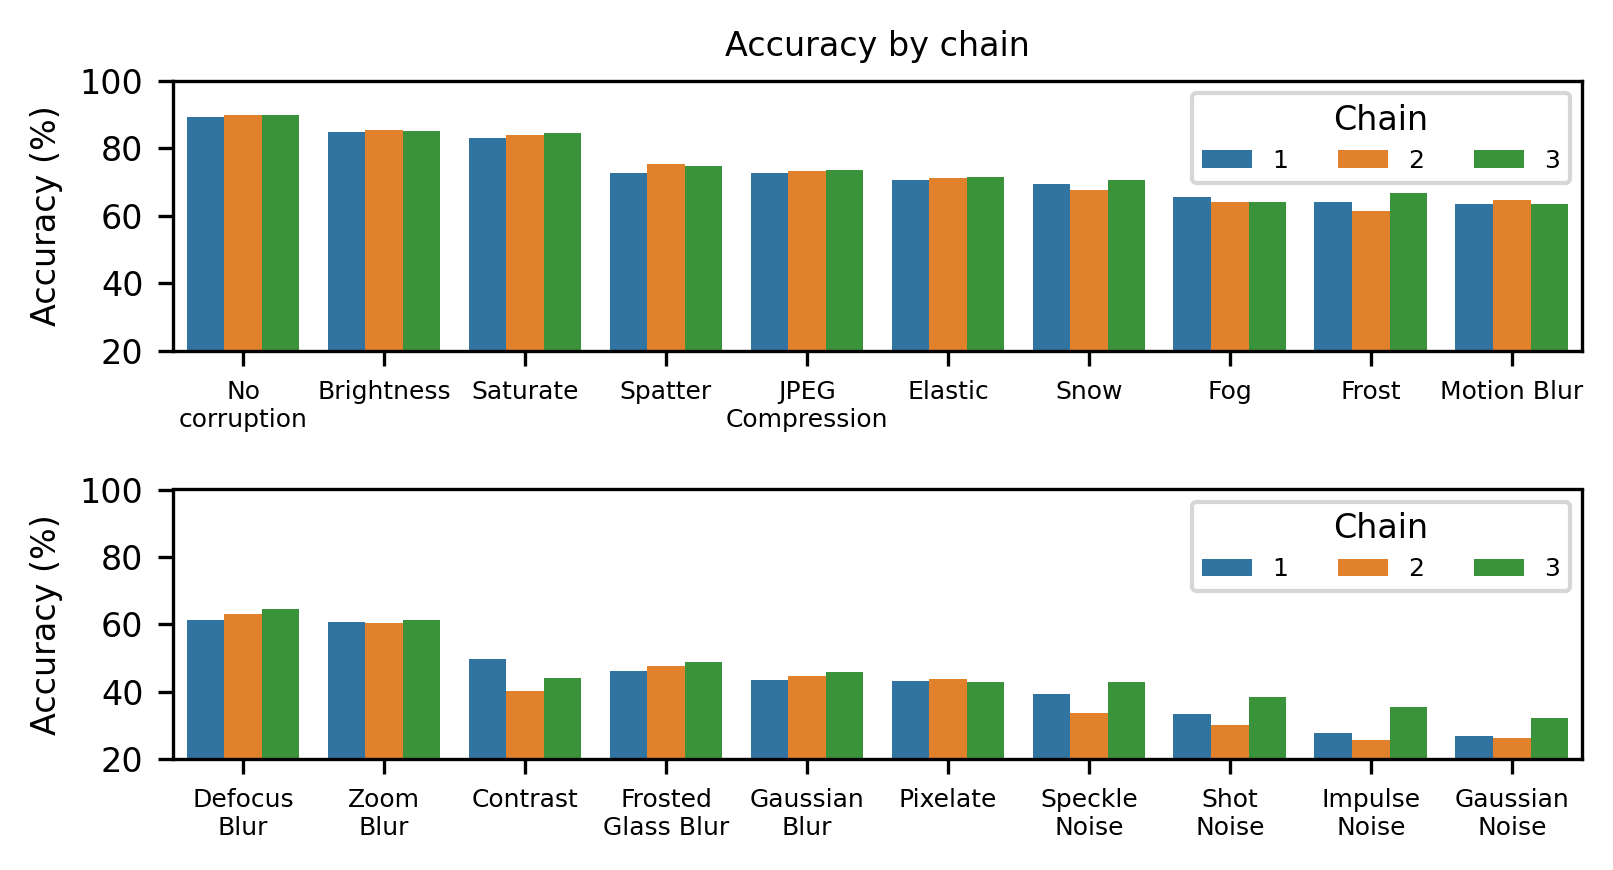

In [19]:
plt.figure(figsize=(5.5, 3), dpi=300)

plt.subplot(211)
sns.color_palette('colorblind')
sns.barplot(data=all_corruptions_df[all_corruptions_df["bootstrapped"]==False], hue="chain", x="name", y="acc", 
            order=list(all_corruptions_df.groupby("name").mean().sort_values("acc", ascending=False).index)[:10])
plt.xticks(fontsize=6, rotation=-45, ha="left")
plt.legend(ncol=3, title="Chain", fontsize=6, title_fontsize=8)
plt.ylim([0.2, 1.0])
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], ["20", "40", "60", "80", "100"], fontsize=8)
plt.ylabel("Accuracy (%)", fontsize=8)
plt.xlabel("")
plt.title("Accuracy by chain", fontsize=8)
plt.xticks(list(range(10)), ["No\ncorruption", "Brightness", "Saturate", "Spatter", "JPEG\nCompression", "Elastic", "Snow", "Fog", "Frost", "Motion Blur"], 
  ha="center", rotation=0, fontsize=6)

plt.subplot(212)
sns.color_palette('colorblind')
sns.barplot(data=all_corruptions_df[all_corruptions_df["bootstrapped"]==False], hue="chain", x="name", y="acc", 
            order=list(all_corruptions_df.groupby("name").mean().sort_values("acc", ascending=False).index)[10:])
plt.xticks(fontsize=6, rotation=-45, ha="left")
plt.legend(ncol=3, title="Chain", fontsize=6, title_fontsize=8)
plt.ylim([0.2, 1.0])
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], ["20", "40", "60", "80", "100"], fontsize=8)
plt.ylabel("Accuracy (%)", fontsize=8)
plt.xlabel("")
plt.xticks(list(range(10)), ["Defocus\nBlur", "Zoom\nBlur", "Contrast", "Frosted\nGlass Blur", "Gaussian\nBlur", "Pixelate", "Speckle\nNoise", "Shot\nNoise", "Impulse\nNoise", "Gaussian\nNoise"], 
  ha="center", rotation=0, fontsize=6)
plt.tight_layout()
plt.savefig("hmc_all_accs.pdf", bbox_inches="tight")

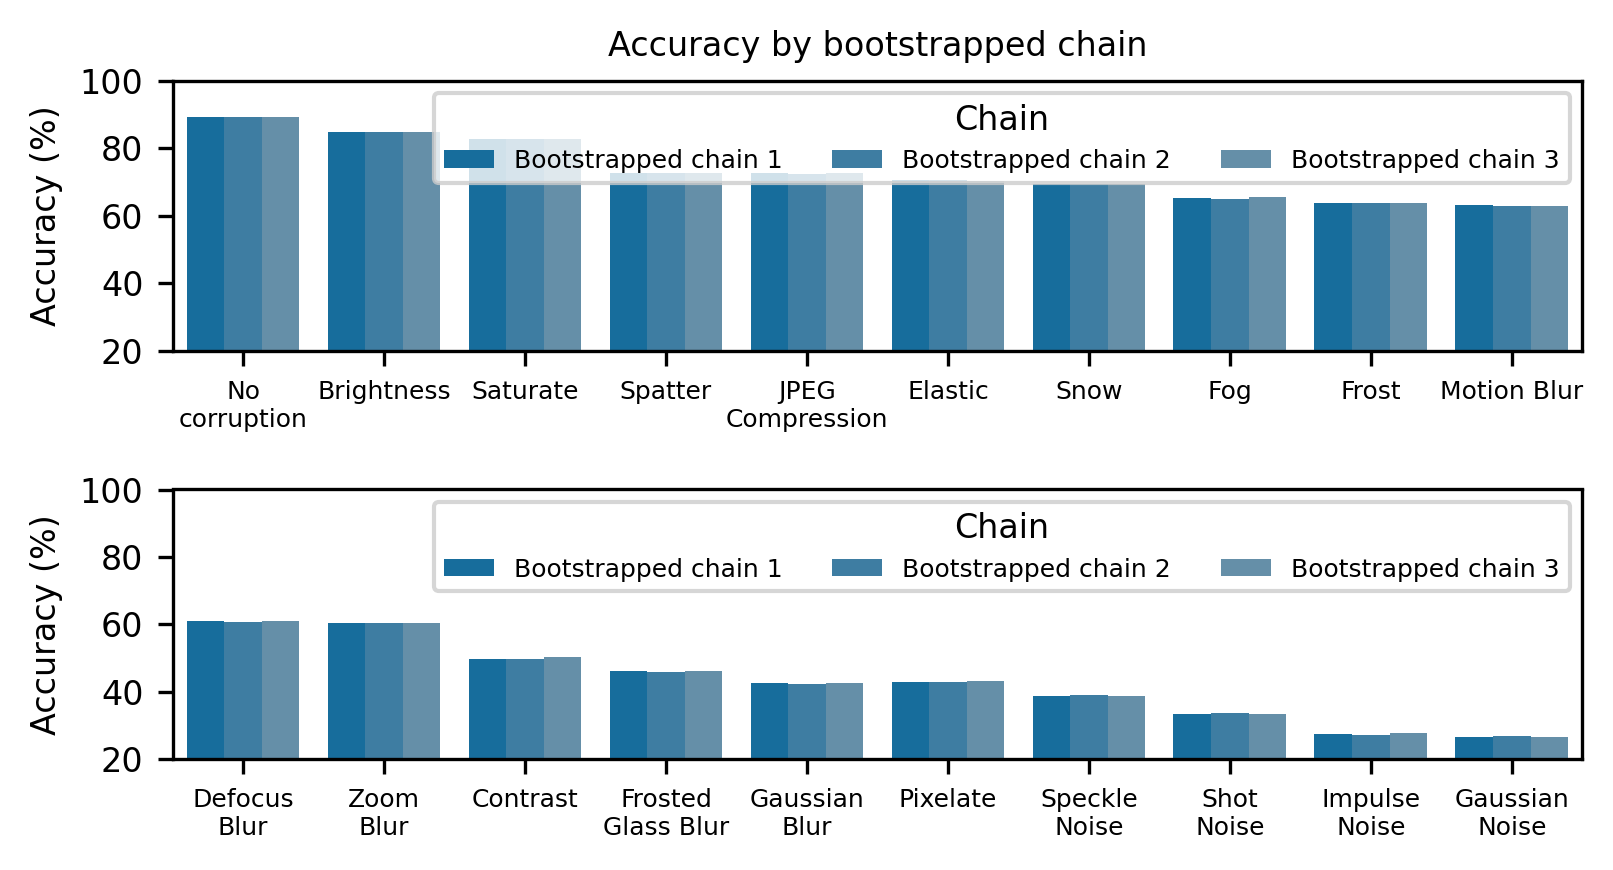

In [20]:
plt.figure(figsize=(5.5, 3), dpi=300)

plt.subplot(211)
sns.color_palette('colorblind')
sns.barplot(data=all_corruptions_df[all_corruptions_df["bootstrapped"]==True], hue="chain", x="name", y="acc", 
            order=list(all_corruptions_df.groupby("name").mean().sort_values("acc", ascending=False).index)[:10], palette=[sns.color_palette('colorblind')[0], 
                                                                                                                                     (45/255.0, 130/255.0, 179/255.0), 
                                                                                                                                     (90/255.0, 146/255.0, 179/255.0)])
plt.xticks(fontsize=6, rotation=-45, ha="left")
plt.legend(plt.gca().get_legend_handles_labels()[0], ["Bootstrapped chain 1", "Bootstrapped chain 2", "Bootstrapped chain 3"], ncol=3, title="Chain", fontsize=6, title_fontsize=8)
plt.ylim([0.2, 1.0])
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], ["20", "40", "60", "80", "100"], fontsize=8)
plt.ylabel("Accuracy (%)", fontsize=8)
plt.xlabel("")
plt.title("Accuracy by bootstrapped chain", fontsize=8)
plt.xticks(list(range(10)), ["No\ncorruption", "Brightness", "Saturate", "Spatter", "JPEG\nCompression", "Elastic", "Snow", "Fog", "Frost", "Motion Blur"], 
  ha="center", rotation=0, fontsize=6)

plt.subplot(212)
sns.color_palette('colorblind')
sns.barplot(data=all_corruptions_df[all_corruptions_df["bootstrapped"]==True], hue="chain", x="name", y="acc", 
            order=list(all_corruptions_df.groupby("name").mean().sort_values("acc", ascending=False).index)[10:], palette=[sns.color_palette('colorblind')[0], 
                                                                                                                                     (45/255.0, 130/255.0, 179/255.0), 
                                                                                                                                     (90/255.0, 146/255.0, 179/255.0)])
plt.xticks(fontsize=6, rotation=-45, ha="left")
plt.legend(plt.gca().get_legend_handles_labels()[0], ["Bootstrapped chain 1", "Bootstrapped chain 2", "Bootstrapped chain 3"], ncol=3, title="Chain", fontsize=6, title_fontsize=8)
plt.ylim([0.2, 1.0])
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], ["20", "40", "60", "80", "100"], fontsize=8)
plt.ylabel("Accuracy (%)", fontsize=8)
plt.xlabel("")
plt.xticks(list(range(10)), ["Defocus\nBlur", "Zoom\nBlur", "Contrast", "Frosted\nGlass Blur", "Gaussian\nBlur", "Pixelate", "Speckle\nNoise", "Shot\nNoise", "Impulse\nNoise", "Gaussian\nNoise"], 
  ha="center", rotation=0, fontsize=6)
plt.tight_layout()
plt.savefig("hmc_all_accs_bootstrapped.pdf", bbox_inches="tight")

In [21]:
import arviz as az

corruption_intensity = 5
convergence_df_list = []

fnames = [f"/content/drive/MyDrive/ColabDrive/hmc_investigations/{corruption}_{corruption_intensity}_logits.npy" for corruption in corruptions]
names = [corruption for corruption in corruptions]
fnames.append("/content/drive/MyDrive/ColabDrive/hmc_investigations/test_logits.npy")
names.append("No corruption")

for fname, name in tqdm(zip(fnames, names)):
  logits = onp.load(fname)
  probs = softmax(logits, axis=-1)

  per_chain_preds = probs.mean(axis=2).argmax(-1)
  agree = (per_chain_preds == per_chain_preds[:, 0].reshape((10000, 1))).sum(axis=-1) == 3

  corruption_dict = {
        "agreement": agree.mean(),
        "name": name,
        "bootstrapped": False
  }
  convergence_df_list.append(corruption_dict)
  
  base_chain_logits = logits[:, base_chain, :, :]
  
  logits[:, 0, :, :] = base_chain_logits[:, chain_indices[0, :], :]
  logits[:, 1, :, :] = base_chain_logits[:, chain_indices[1, :], :]
  logits[:, 2, :, :] = base_chain_logits[:, chain_indices[2, :], :]
  
  probs = softmax(logits, axis=-1)

  per_chain_preds = probs.mean(axis=2).argmax(-1)
  agree = (per_chain_preds == per_chain_preds[:, 0].reshape((10000, 1))).sum(axis=-1) == 3

  corruption_dict = {
        "agreement": agree.mean(),
        "name": name,
        "bootstrapped": True
  }
  convergence_df_list.append(corruption_dict)

convergence_df = pd.DataFrame(convergence_df_list)  

20it [02:34,  7.71s/it]


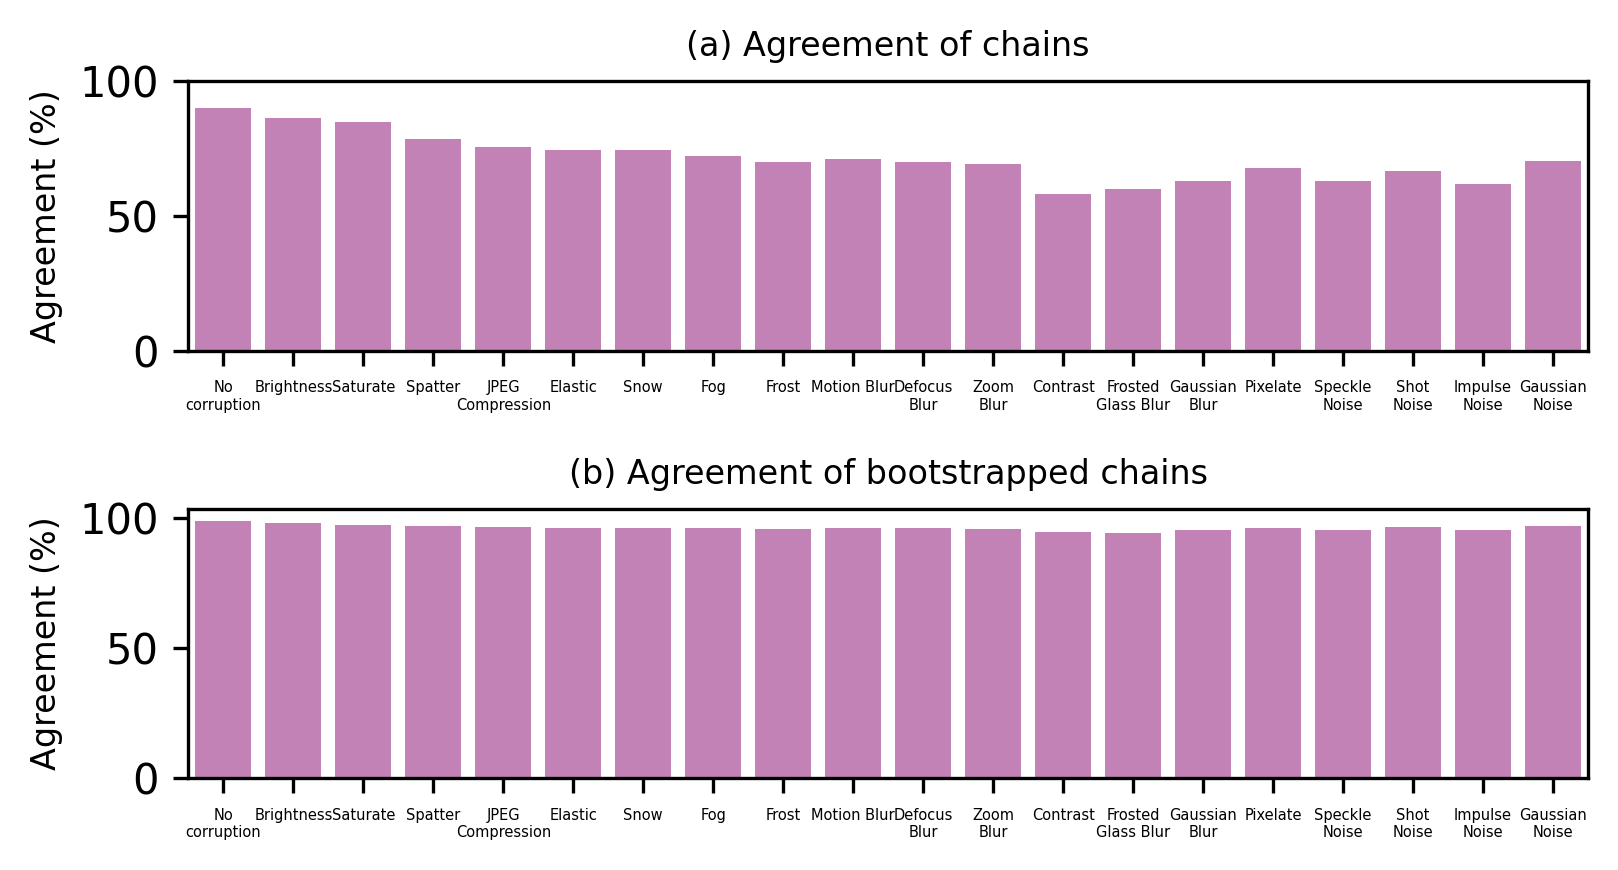

In [39]:
plt.figure(figsize=(5.5, 3), dpi=300)

plt.subplot(211)
sns.color_palette('colorblind')
sns.barplot(data=convergence_df[convergence_df["bootstrapped"]==False], x="name", y="agreement", color=sns.color_palette('colorblind')[4],
            order=list(all_corruptions_df.groupby("name").mean().sort_values("acc", ascending=False).index))
plt.xticks(list(range(20)), ["No\ncorruption", "Brightness", "Saturate", "Spatter", "JPEG\nCompression", "Elastic", "Snow", "Fog", "Frost", "Motion Blur" ,"Defocus\nBlur", "Zoom\nBlur", "Contrast", "Frosted\nGlass Blur", "Gaussian\nBlur", "Pixelate", "Speckle\nNoise", "Shot\nNoise", "Impulse\nNoise", "Gaussian\nNoise"], 
  ha="center", rotation=0, fontsize=3.5)
plt.title("(a) Agreement of chains", fontsize=8)
plt.xlabel("")
plt.ylabel("Agreement (%)", fontsize=8)
plt.yticks([0, 0.5, 1], [0, 50, 100])

plt.subplot(212)
sns.color_palette('colorblind')
sns.barplot(data=convergence_df[convergence_df["bootstrapped"]==True], x="name", y="agreement", color=sns.color_palette('colorblind')[4],
            order=list(all_corruptions_df.groupby("name").mean().sort_values("acc", ascending=False).index))
plt.xticks(fontsize=6, rotation=-45, ha="center")
plt.title("(b) Agreement of bootstrapped chains", fontsize=8)
plt.xlabel("")
plt.ylabel("Agreement (%)", fontsize=8)
plt.yticks([0, 0.5, 1], [0, 50, 100])

plt.xticks(list(range(20)), ["No\ncorruption", "Brightness", "Saturate", "Spatter", "JPEG\nCompression", "Elastic", "Snow", "Fog", "Frost", "Motion Blur" ,"Defocus\nBlur", "Zoom\nBlur", "Contrast", "Frosted\nGlass Blur", "Gaussian\nBlur", "Pixelate", "Speckle\nNoise", "Shot\nNoise", "Impulse\nNoise", "Gaussian\nNoise"], 
  ha="center", rotation=0, fontsize=3.5)

plt.tight_layout()
plt.savefig("hmc_agreement_all.pdf", bbox_inches="tight")

# Creating Plot for Paper

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

In [41]:
order = ["No corruption", "contrast", "speckle_noise", "shot_noise", "impulse_noise", "gaussian_noise"]

([<BarContainer object of 6 artists>, <BarContainer object of 6 artists>, <BarContainer object of 6 artists>], ['1', '2', '3'])


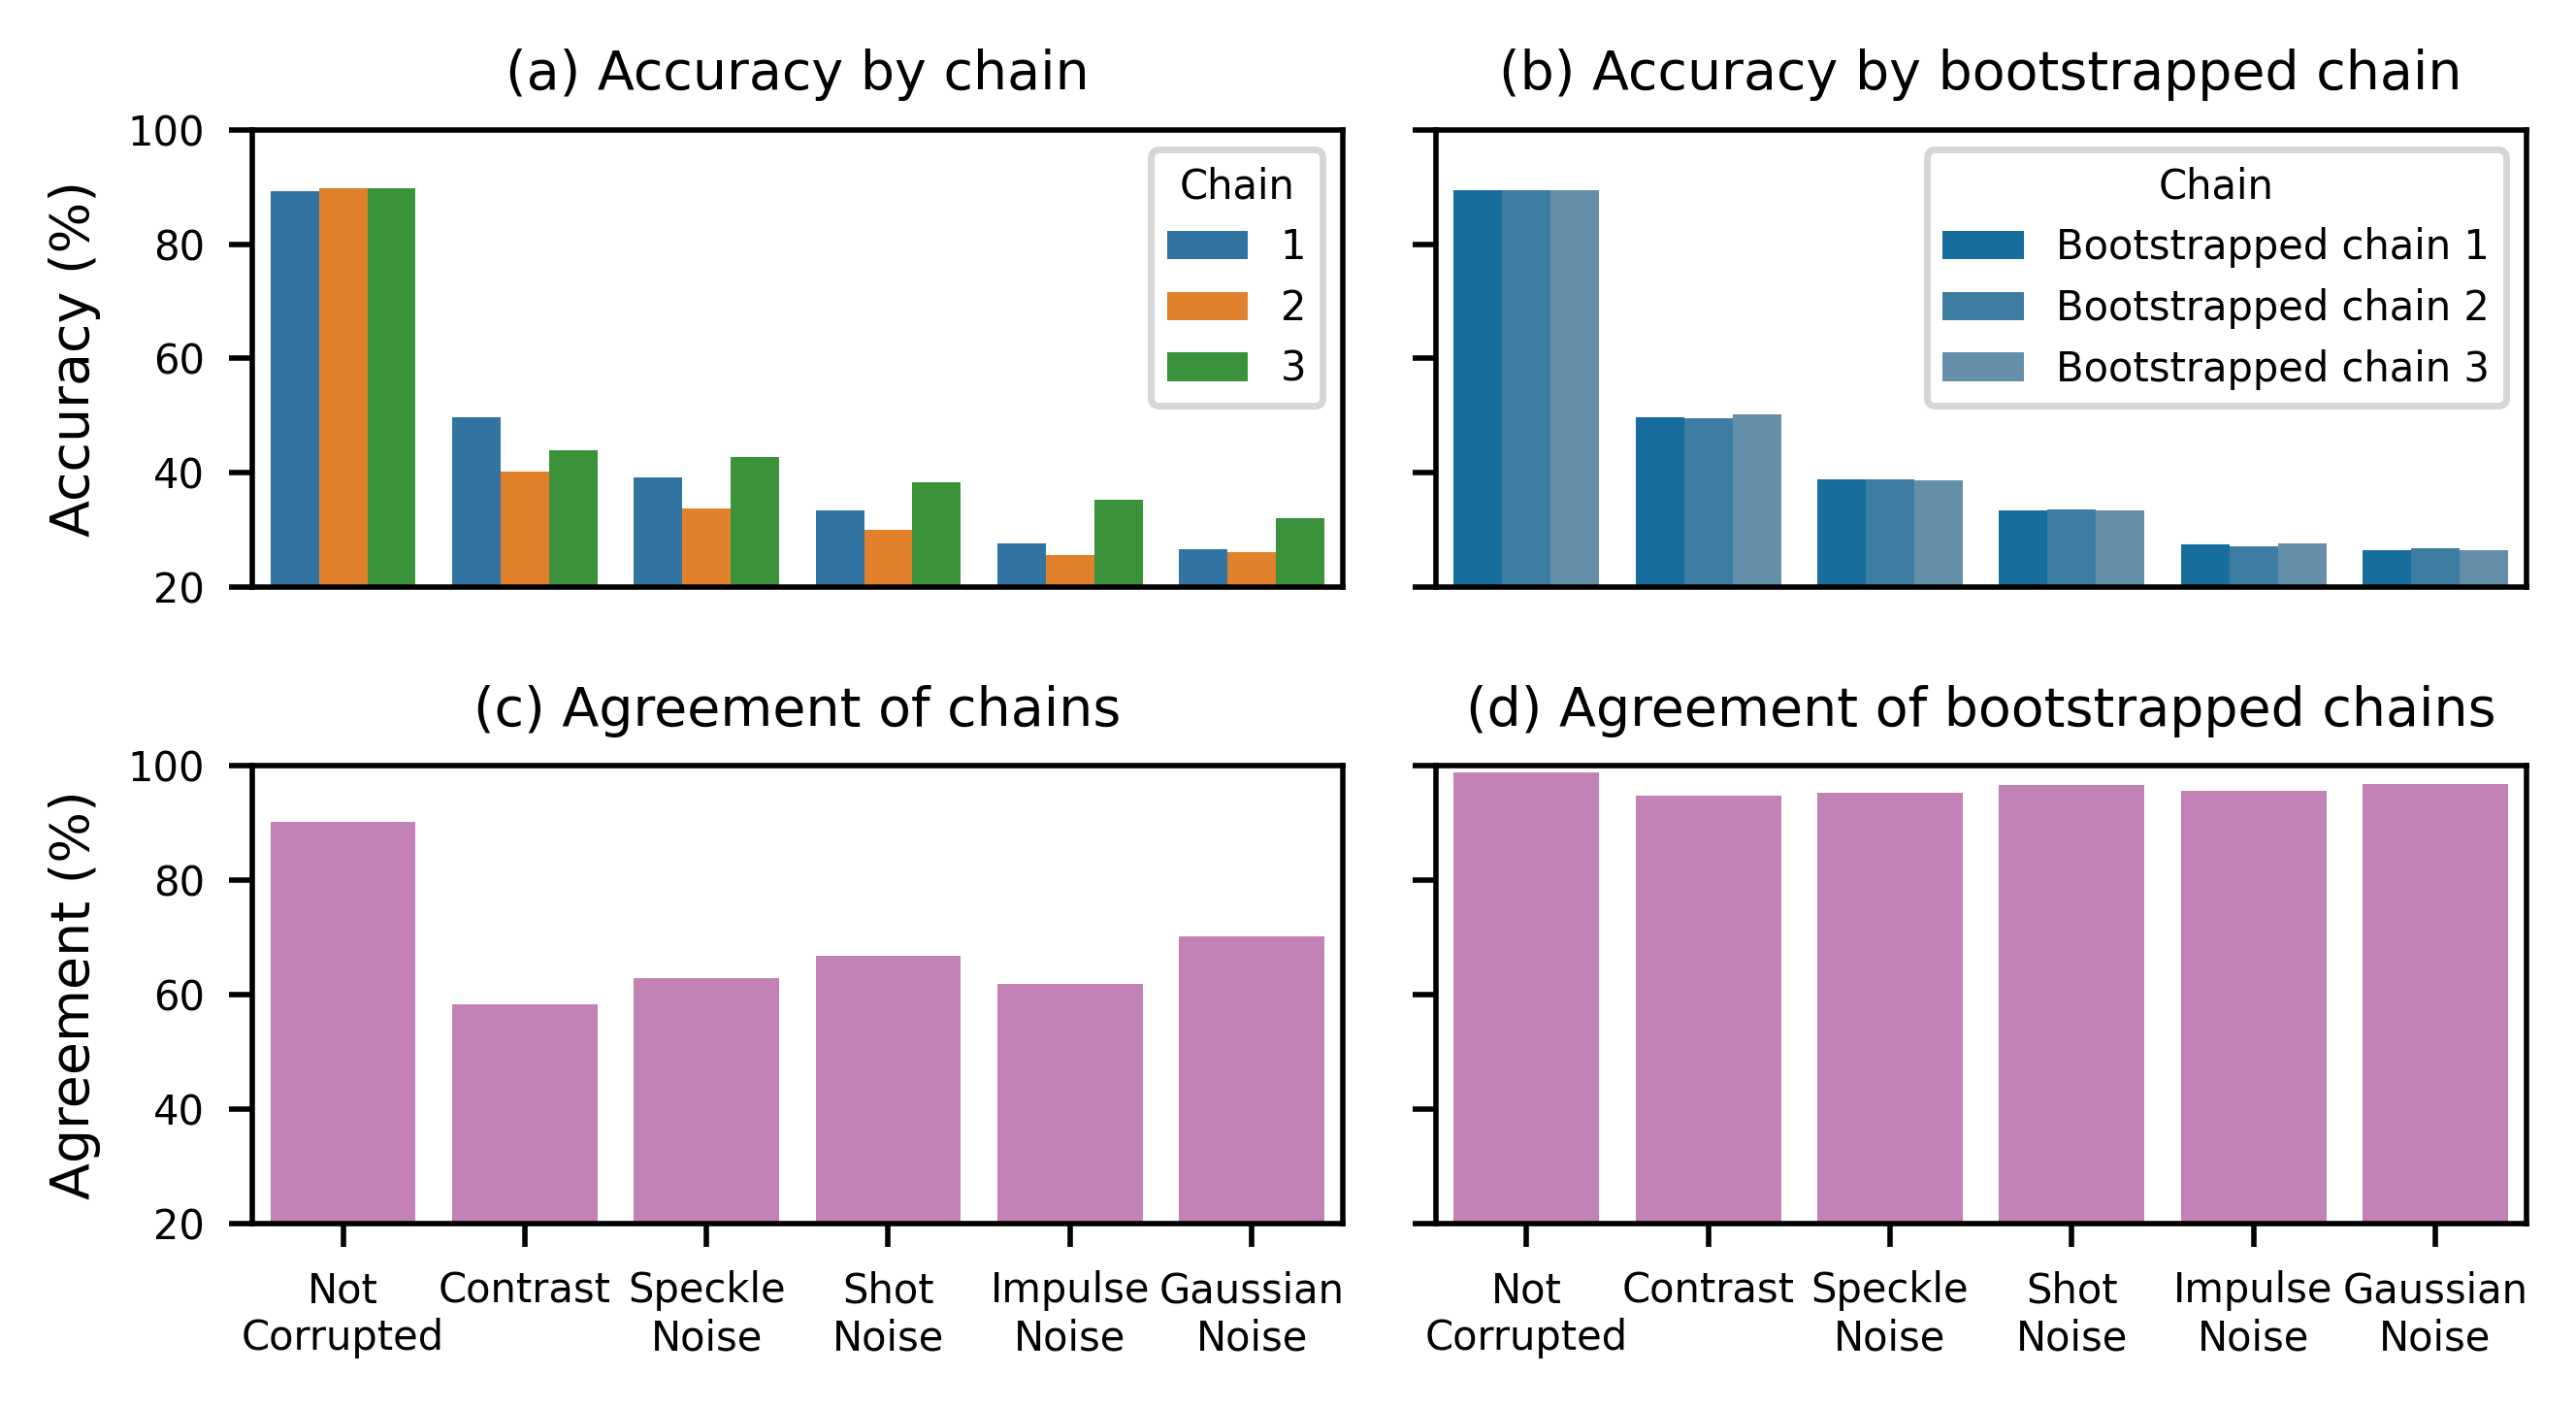

In [42]:
fig = plt.figure(figsize=(5.5, 3), dpi=500)

plt.subplot(2, 2, 1)
sns.color_palette('colorblind')
sns.barplot(data=all_corruptions_df[all_corruptions_df["bootstrapped"]==False], hue="chain", x="name", y="acc", order=order)
plt.xticks(fontsize=6, rotation=-45, ha="left")
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], ["20", "40", "60", "80", "100"], fontsize=6)
plt.legend(ncol=1, title="Chain", fontsize=6, title_fontsize=6)
plt.ylim([0.2, 1.0])
plt.ylabel("Accuracy (%)", fontsize=8)
plt.title("(a) Accuracy by chain", fontsize=8)
plt.xlabel(None)
plt.xticks(list(range(6)), ["No corruption", "Constrast", "Speckle Noise", "Shot Noise", "Impulse Noise", "Gaussian Noise"], ha="left")
plt.xticks([])

plt.subplot(2, 2, 3)
sns.color_palette('colorblind')
sns.barplot(data=convergence_df[convergence_df["bootstrapped"]==False], x="name", y="agreement", color=sns.color_palette('colorblind')[4], order=order)
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], ["20", "40", "60", "80", "100"], fontsize=6)
plt.ylim([0.2, 1])
plt.ylabel("Agreement (%)", fontsize=8)
plt.title("(c) Agreement of chains", fontsize=8)
plt.xlabel(None)
plt.xticks(list(range(6)), ["Not\nCorrupted", "Contrast", "Speckle\nNoise", "Shot\nNoise", "Impulse\nNoise", "Gaussian\nNoise"], fontsize=6, rotation=0)

plt.subplot(2, 2, 2)
sns.color_palette('colorblind')
sns.barplot(data=all_corruptions_df[all_corruptions_df["bootstrapped"]==True], hue="chain", x="name", y="acc", order=order, palette=[sns.color_palette('colorblind')[0], 
                                                                                                                                     (45/255.0, 130/255.0, 179/255.0), 
                                                                                                                                     (90/255.0, 146/255.0, 179/255.0)])
plt.xticks(fontsize=6, rotation=-45, ha="left")
# plt.yticks([0.2, 0.4, 0.6, 0.8], ["20", "40", "60", "80"], fontsize=6)
print(plt.gca().get_legend_handles_labels())
plt.legend(plt.gca().get_legend_handles_labels()[0], ["Bootstrapped chain 1", "Bootstrapped chain 2", "Bootstrapped chain 3"], ncol=1, title="Chain", fontsize=6, title_fontsize=6)
plt.ylim([0.2, 1.0])
plt.ylabel("Accuracy (%)", fontsize=8)
plt.ylabel(None)
plt.title("(b) Accuracy by bootstrapped chain", fontsize=8)
plt.xlabel(None)
plt.xticks(list(range(6)), ["No corruption", "Constrast", "Speckle Noise", "Shot Noise", "Impulse Noise", "Gaussian Noise"], fontsize=6, rotation=0)
plt.xticks([])
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], [], fontsize=6)

plt.subplot(2, 2, 4)
sns.color_palette('colorblind')
sns.barplot(data=convergence_df[convergence_df["bootstrapped"]==True], x="name", y="agreement", color=sns.color_palette('colorblind')[4], order=order)
# plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], ["20", "40", "60", "80", "100"], fontsize=6)
plt.ylim([0.2, 1])
plt.ylabel(None)
plt.title("(d) Agreement of bootstrapped chains", fontsize=8)
plt.xlabel(None)
plt.xticks(list(range(6)), ["Not\nCorrupted", "Contrast", "Speckle\nNoise", "Shot\nNoise", "Impulse\nNoise", "Gaussian\nNoise"], fontsize=6, rotation=0)
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], [], fontsize=6)

plt.tight_layout(w_pad=0.5)
# plt.text(0.25, 0.98, "Original Chains", transform=fig.transFigure, ha="center", fontsize=12)
# plt.text(0.75, 0.98, "Bootstrapped Chains", transform=fig.transFigure, ha="center", fontsize=12)
plt.savefig("hmc_issues_with_sampling_variability.pdf", bbox_inches="tight")